In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn

### Data Preparation

In [2]:
df=pd.read_csv("stock_price_prediction_dataset.csv")

In [3]:
df.head()

,Date,Open Price,High Price,Low Price,Close Price,Volume,Stock Code,Sector,Moving Average,Sentiment Score
0,01-01-2020,137.45,NaN,124.48,137.61,2614.0,GOOGL,Tech,0.00,-0.91
1,02-01-2020,195.07,211.00,191.62,199.23,5555.0,AAPL,Finance,0.00,0.68
2,03-01-2020,173.20,178.21,155.75,169.05,3416.0,AAPL,Healthcare,0.00,NaN
3,04-01-2020,159.87,172.37,147.61,159.95,8288.0,AMZN,Healthcare,0.00,0.39
4,05-01-2020,115.60,127.03,112.46,118.36,7862.0,GOOGL,Tech,156.84,-0.55


In [4]:
df['Stock Code'].unique()

array(['GOOGL', 'AAPL', 'AMZN', 'TSLA', 'MSFT'], dtype=object)

In [5]:
df.columns

Index(['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price',
       'Volume', 'Stock Code', 'Sector', 'Moving Average', 'Sentiment Score'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             3000 non-null   object 
 1   Open Price       2850 non-null   float64
 2   High Price       2850 non-null   float64
 3   Low Price        2850 non-null   float64
 4   Close Price      2850 non-null   float64
 5   Volume           2850 non-null   float64
 6   Stock Code       3000 non-null   object 
 7   Sector           3000 non-null   object 
 8   Moving Average   2850 non-null   float64
 9   Sentiment Score  2850 non-null   float64
dtypes: float64(7), object(3)
memory usage: 234.5+ KB


In [7]:
df.describe()

,Open Price,High Price,Low Price,Close Price,Volume,Moving Average,Sentiment Score
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,149.890281,160.012242,140.484214,149.885604,5532.294386,149.931726,0.024323
std,29.159877,29.653965,29.620107,29.236836,2599.092823,14.237896,0.574660
min,100.000000,100.810000,81.960000,95.170000,1004.000000,0.000000,-1.000000
25%,124.267500,134.525000,115.170000,124.490000,3291.000000,140.562500,-0.460000
50%,150.325000,160.445000,141.610000,150.545000,5561.500000,150.035000,0.045000
75%,175.262500,185.165000,165.787500,174.812500,7816.000000,159.710000,0.510000
max,199.970000,217.870000,198.240000,203.890000,9998.000000,185.840000,1.000000


In [8]:
df.isnull().sum()

Date                 0
Open Price         150
High Price         150
Low Price          150
Close Price        150
Volume             150
Stock Code           0
Sector               0
Moving Average     150
Sentiment Score    150
dtype: int64

### Imputation

In [9]:
cat_cols= df.select_dtypes(include=['object']).columns.tolist()
num_cols= df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)
for col in cat_cols:
    df[col]=df[col].fillna(df[col].mode()[0])
# In fact no cat cols have null values, but this is a good practice to handle them
for col in num_cols:
    df[col]=df[col].fillna(df[col].median())

Categorical Columns: ['Date', 'Stock Code', 'Sector']
Numerical Columns: ['Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume', 'Moving Average', 'Sentiment Score']


In [10]:
df.isnull().sum()

Date               0
Open Price         0
High Price         0
Low Price          0
Close Price        0
Volume             0
Stock Code         0
Sector             0
Moving Average     0
Sentiment Score    0
dtype: int64

In [11]:
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y',errors='coerce')
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0 = Monday
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)

These features help capture patterns like:

* Seasonality (e.g., stock spikes at end of quarter)

* Day-of-week trends (e.g., Monday dips)

In [12]:
df.drop('Date', axis=1, inplace=True)

### Encoding

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open Price       3000 non-null   float64
 1   High Price       3000 non-null   float64
 2   Low Price        3000 non-null   float64
 3   Close Price      3000 non-null   float64
 4   Volume           3000 non-null   float64
 5   Stock Code       3000 non-null   object 
 6   Sector           3000 non-null   object 
 7   Moving Average   3000 non-null   float64
 8   Sentiment Score  3000 non-null   float64
 9   Day              3000 non-null   int32  
 10  Month            3000 non-null   int32  
 11  Year             3000 non-null   int32  
 12  DayOfWeek        3000 non-null   int32  
 13  IsMonthEnd       3000 non-null   int64  
dtypes: float64(7), int32(4), int64(1), object(2)
memory usage: 281.4+ KB


In [14]:
df=pd.get_dummies(df,columns=['Stock Code','Sector'],drop_first=True)

In [15]:
df.head()

,Open Price,High Price,Low Price,Close Price,Volume,Moving Average,Sentiment Score,Day,Month,Year,DayOfWeek,IsMonthEnd,Stock Code_AMZN,Stock Code_GOOGL,Stock Code_MSFT,Stock Code_TSLA,Sector_Energy,Sector_Finance,Sector_Healthcare,Sector_Tech
0,137.45,160.445,124.48,137.61,2614.0,0.00,-0.910,1,1,2020,2,0,False,True,False,False,False,False,False,True
1,195.07,211.000,191.62,199.23,5555.0,0.00,0.680,2,1,2020,3,0,False,False,False,False,False,True,False,False
2,173.20,178.210,155.75,169.05,3416.0,0.00,0.045,3,1,2020,4,0,False,False,False,False,False,False,True,False
3,159.87,172.370,147.61,159.95,8288.0,0.00,0.390,4,1,2020,5,0,True,False,False,False,False,False,True,False
4,115.60,127.030,112.46,118.36,7862.0,156.84,-0.550,5,1,2020,6,0,False,True,False,False,False,False,False,True


In [16]:
X = df.drop('Close Price', axis=1).values
y = df['Close Price'].values.reshape(-1, 1)

### Normalization and Split

In [17]:


# Normalize the features and labels
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


### Convert to Tensors

In [18]:
import torch
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

### Defining the Model

In [19]:
class StockPredictor(nn.Module):
    def __init__(self, input_size, activation='relu'):
        super(StockPredictor, self).__init__()
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }
        act_fn = activations.get(activation, nn.ReLU())
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            act_fn,
            nn.Linear(64, 32),
            act_fn,
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

### Training

In [20]:
def train_model(activation_fn, input_size, train_loader, X_test, y_test, epochs=100):
    model = StockPredictor(input_size, activation=activation_fn)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    grad_norm_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_grad_norm = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            # Compute gradient norm
            grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    grad_norm += param.grad.norm().item()
            total_grad_norm += grad_norm
            optimizer.step()
            total_loss += loss.item()
        loss_history.append(total_loss)
        grad_norm_history.append(total_grad_norm)
    # Evaluate on test set
    model.eval()

    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
        # y_pred = y_pred_scaled
        # y_test_inv = y_test

    return loss_history, grad_norm_history, y_pred_scaled
    

input_size = X_train.shape[1]

# Train with leaky_relu
leaky_relu_loss, leaky_relu_grad, leaky_relu_pred = train_model('leaky_relu', input_size, train_loader, X_test, y_test, epochs=100)

# Train with sigmoid
sigmoid_loss, sigmoid_grad, sigmoid_pred = train_model('sigmoid', input_size, train_loader, X_test, y_test, epochs=100)



## Testing

### Visualization and Plot

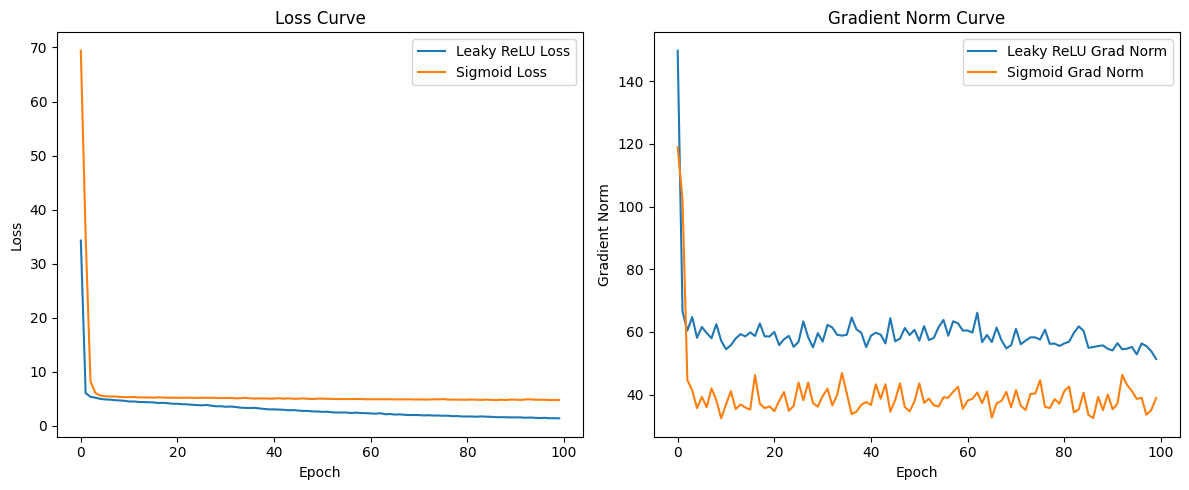

In [21]:
import seaborn as sns
# Plot loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(leaky_relu_loss, label='Leaky ReLU Loss')
plt.plot(sigmoid_loss, label='Sigmoid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot gradient norms
plt.subplot(1,2,2)
plt.plot(leaky_relu_grad, label='Leaky ReLU Grad Norm')
plt.plot(sigmoid_grad, label='Sigmoid Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Curve')
plt.legend()
plt.tight_layout()
plt.show()

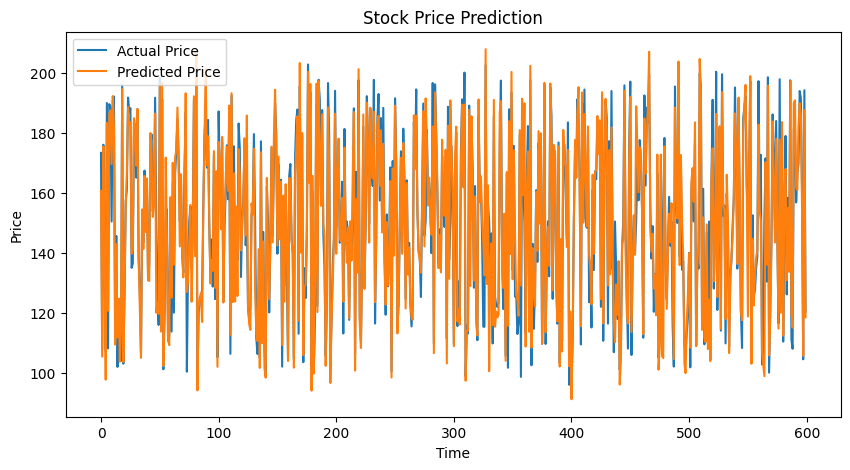

In [22]:
# Inverse transform predictions as to compare with actual values
y_pred_inv = y_scaler.inverse_transform(leaky_relu_pred)
y_test_inv = y_scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


### Accuracy metrics

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate metrics on test data (using leaky_relu predictions as example)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 73.5622
Root Mean Squared Error (RMSE): 8.5768
R² Score: 0.9105


## Findings

### 1. Loss Curve (Left Plot):
- The loss curves for both Leaky ReLU and Sigmoid activations decrease over epochs, indicating that the models are learning and the training process is effective.
- The **Leaky ReLU** loss decreases more quickly and stabilizes at a lower value compared to Sigmoid, suggesting that Leaky ReLU leads to better model performance and faster convergence.
- The Sigmoid curve is higher and may decrease more slowly, which can be due to vanishing gradient issues common with Sigmoid activations in deeper networks.

### 2. Gradient Norm Curve (Right Plot):
- The gradient norm for **Leaky ReLU** remains relatively stable and does not vanish, which helps the model continue learning throughout training.
- The gradient norm for Sigmoid is generally lower and may decrease more, indicating the gradients are smaller and learning can slow down (vanishing gradient problem).
- Stable and non-vanishing gradients (as seen with Leaky ReLU) are desirable for effective training.

### 3. Evaluation Metrics (Test Set):

- Mean Squared Error (MSE): 73.03
- Root Mean Squared Error (RMSE): 8.55 (average prediction error in stock price units)
- **R² Score: 0.91 → Model explains 91% of the variance in stock prices.**

This R² can be interpreted as ~91% accuracy in capturing stock price behavior.

## Summary:
- **Leaky ReLU** clearly outperforms **Sigmoid** in terms of loss reduction gradient stability and predictive accuracy.
- Leaky ReLU is less prone to vanishing gradients, enables faster and more effective learning and it achieves ~91% accuracy (R² = 0.91) on the test data..
- For stock price regression task, Leaky ReLU is the preferred activation function.